In [2]:
pip install -qqq torch pandas numpy matplotlib yfinance scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -qqq yfinance

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os, math, time, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Reproducibility (helps for CPU determinism) ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cpu")  # force CPU

# --- Download data ---
ticker = "SPY"     # change to any liquid ETF or stock
period = "10y"     # or e.g., "5y"
price = yf.download(ticker, period=period, auto_adjust=False)["Adj Close"].dropna()
assert len(price) > 300, "Need at least ~300 daily points; try a longer period."

# --- Log returns ---
rets = np.log(price).diff().dropna()
rets = rets.astype("float32")
print(f"Loaded {len(rets)} daily returns for {ticker}")
rets.head()


[*********************100%***********************]  1 of 1 completed

Loaded 2513 daily returns for SPY


Ticker,SPY
Date,
2015-09-28,-0.025418
2015-09-29,0.000585
2015-09-30,0.018486
2015-10-01,0.002606
2015-10-02,0.014828


In [7]:
# Hyperparams
SEQ_LEN = 64           # days per training window
HORIZON = 64           # forecast horizon (days) to simulate
STEP = 1               # stride between windows
BATCH_SIZE = 256
LATENT_DIM = 6         # small latent works fine on CPU
EPOCHS = 30            # ~1–5 minutes on CPU depending on data & machine
LR = 1e-3

# Build dataset of overlapping windows of length SEQ_LEN
def build_windows(series, seq_len, step=1):
    x = series.values if isinstance(series, pd.Series) else series
    X = [x[i:i+seq_len] for i in range(0, len(x)-seq_len, step)]
    return np.array(X, dtype=np.float32)

X = build_windows(rets, SEQ_LEN, STEP)
X_torch = torch.from_numpy(X).unsqueeze(1)  # [N, 1, T]
N = len(X_torch)
print(f"Training windows: {N}, shape per sample: {X_torch.shape}")


Training windows: 2449, shape per sample: torch.Size([2449, 1, 64, 1])


In [8]:
class VAE(nn.Module):
    def __init__(self, T=SEQ_LEN, z=LATENT_DIM, hidden=128):
        super().__init__()
        self.T = T
        self.enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(T, hidden),
            nn.ReLU(),
        )
        self.mu = nn.Linear(hidden, z)
        self.logvar = nn.Linear(hidden, z)
        self.dec = nn.Sequential(
            nn.Linear(z, hidden),
            nn.ReLU(),
            nn.Linear(hidden, T)
        )

    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)

    def reparam(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + torch.exp(0.5 * logvar) * eps

    def decode(self, z):
        out = self.dec(z)
        return out.unsqueeze(1)  # [B, 1, T]

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        recon = self.decode(z)
        # MSE recon + KL
        rec = F.mse_loss(recon, x, reduction='mean')
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return rec + 1e-3 * kl, rec, kl

vae = VAE().to(device)
opt = torch.optim.Adam(vae.parameters(), lr=LR)

def batches(X, bs):
    for i in range(0, len(X), bs):
        yield X[i:i+bs]

# Training loop (CPU-friendly)
vae.train()
t0 = time.time()
for epoch in range(1, EPOCHS+1):
    perm = torch.randperm(N)
    X_epoch = X_torch[perm]
    losses, recs, kls = [], [], []
    for xb in batches(X_epoch, BATCH_SIZE):
        xb = xb.to(device)
        loss, rec, kl = vae(xb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item()); recs.append(rec.item()); kls.append(kl.item())
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:>3}/{EPOCHS} | loss={np.mean(losses):.6f} rec={np.mean(recs):.6f} kl={np.mean(kls):.6f}")
t1 = time.time()
print(f"Training done in {t1 - t0:.1f}s on CPU.")


Epoch   1/30 | loss=0.034125 rec=0.034122 kl=0.003544
Epoch   5/30 | loss=0.003068 rec=0.003049 kl=0.018709
Epoch  10/30 | loss=0.001220 rec=0.001179 kl=0.040816
Epoch  15/30 | loss=0.000808 rec=0.000745 kl=0.063431
Epoch  20/30 | loss=0.000626 rec=0.000540 kl=0.085968
Epoch  25/30 | loss=0.000545 rec=0.000442 kl=0.103653
Epoch  30/30 | loss=0.000512 rec=0.000403 kl=0.108660
Training done in 102.3s on CPU.


In [10]:
#Scenario Generation 
vae.eval()
with torch.no_grad():
    # --- Conditional seed from last observed window (current regime) ---
    last_window = torch.from_numpy(rets.values[-SEQ_LEN:].astype(np.float32)).view(1,1,-1).to(device)
    mu, logvar = vae.encode(last_window)
    std = torch.exp(0.5 * logvar)

def generate_paths(n_paths=200, conditional=True, start_price=None):
    vae.eval()
    with torch.no_grad():
        if conditional:
            z = mu + std * torch.randn(n_paths, LATENT_DIM).to(device)
        else:
            z = torch.randn(n_paths, LATENT_DIM).to(device)
        # Decode HORIZON-length returns by truncating/rolling if needed
        rets_gen = vae.decode(z).cpu().squeeze(1).numpy()  # [n, T]
        # If SEQ_LEN != HORIZON, adjust (simple approach: take the last HORIZON returns)
        if rets_gen.shape[1] >= HORIZON:
            rets_slice = rets_gen[:, -HORIZON:]
        else:
            # tile to reach desired horizon (keeps code simple)
            reps = int(math.ceil(HORIZON / rets_gen.shape[1]))
            tiled = np.tile(rets_gen, (1, reps))[:, :HORIZON]
            rets_slice = tiled

        # Convert returns → prices
        if start_price is None:
            start_price = float(price.iloc[-1])
        prices = start_price * np.exp(np.cumsum(rets_slice, axis=1))
    return rets_slice, prices

rets_sims, price_sims = generate_paths(n_paths=500, conditional=True)
price_sims.shape


(500, 64)

VaR/CVaR (log-return units):
95%: {'VaR_1d': np.float32(-0.021476852), 'CVaR_1d': np.float32(-0.028097458), 'VaR_horizon': np.float32(-0.19233607), 'CVaR_horizon': np.float32(-0.24786277)}
99%: {'VaR_1d': np.float32(-0.03229333), 'CVaR_1d': np.float32(-0.036228158), 'VaR_horizon': np.float32(-0.27760947), 'CVaR_horizon': np.float32(-0.31084532)}


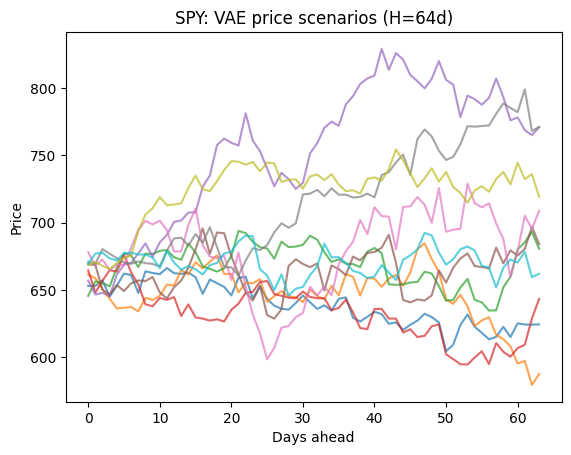

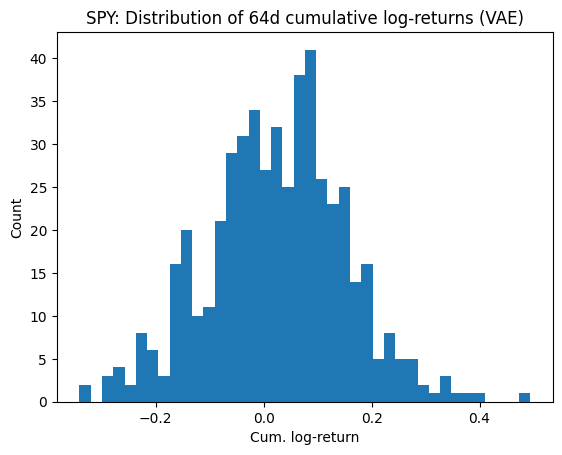

In [11]:
def var_cvar(returns, alpha=0.95):
    """
    returns: array [n_paths, horizon] of daily log returns
    Computes daily VaR/CVaR at alpha for the *next day* and for cumulative horizon.
    """
    # Next day metrics
    day1 = returns[:, 0]
    q = np.quantile(day1, 1 - alpha)
    cvar = day1[day1 <= q].mean() if np.any(day1 <= q) else q
    # Horizon cumulative metrics (sum of log-returns)
    cum = returns.sum(axis=1)
    qH = np.quantile(cum, 1 - alpha)
    cvarH = cum[cum <= qH].mean() if np.any(cum <= qH) else qH
    return {"VaR_1d": q, "CVaR_1d": cvar, "VaR_horizon": qH, "CVaR_horizon": cvarH}

m95 = var_cvar(rets_sims, alpha=0.95)
m99 = var_cvar(rets_sims, alpha=0.99)
print("VaR/CVaR (log-return units):")
print("95%:", m95)
print("99%:", m99)

# Plot a few sample paths
plt.figure()
for i in range(10):
    plt.plot(price_sims[i], alpha=0.7)
plt.title(f"{ticker}: VAE price scenarios (H={HORIZON}d)")
plt.xlabel("Days ahead"); plt.ylabel("Price")
plt.show()

# Distribution of cumulative returns
cum_lr = rets_sims.sum(axis=1)
plt.figure()
plt.hist(cum_lr, bins=40)
plt.title(f"{ticker}: Distribution of {HORIZON}d cumulative log-returns (VAE)")
plt.xlabel("Cumulative log-return"); plt.ylabel("Count")
plt.show()
